# Multilayer Perceptron (MLP) auf MNIST Daten

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/ergodlws/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Definition der Trainingsparameter
- batch_size: Wie viele Trainingsbeispiele werden gleichzeitig verarbeitet?
- num_classes: Wie viele Klassen (unterschiedliche Zahlen) gibt es?
- epochs: Wie oft soll auf dem gesamten Datensatz trainiert werden?

In [2]:
batch_size = 128
num_classes = 10
epochs = 20

## Datevorbereitung

Laden der Daten, bereits nach Training- und Testset getrennt 

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Da das MLP einen eindimensionalen Vektor für jedes Trainingsbeispiel erwartet, transformieren wir die Daten so, dass die Pixel jedes Bildes zeilenweise aneinander gefügt werden.

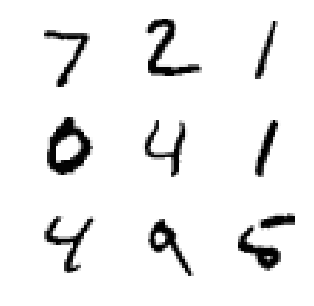

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(5,5))

for sample, ax in zip(x_test, axes.flat):
    ax.imshow(sample, cmap='binary')
    ax.set_axis_off()

In [5]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

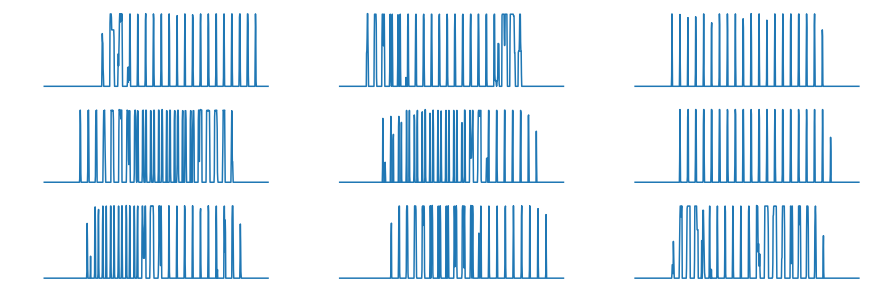

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(15,5))

for sample, ax in zip(x_test, axes.flat):
    ax.plot(sample)
    ax.set_axis_off()

Da die meisten Deep Learning Frameworks nur mit Floats in Single-Precision arbeiten, werden die Daten hier noch nach Float32 konvertiert.

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

Eine übliche Praxis ist das Normalisieren der Daten so, dass die Eingabewerte in der Größenordnung 1.0 liegen. Dies beschleunigt die Konvergenz während des Trainings. In dem Fall der MNIST-Zahlen handelt es sich um Daten in 8-bit Integer-Format, weswegen wir einfach durch den größten 8-bit Integer teilen.

In [8]:
x_train /= 255
x_test /= 255

In [9]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


Hier werden die Zielvariablen (auch Labels oder Targets) in die sog. One-Hot-Darstellung gebracht um zur Ausgabe des MLP zu passen. Dieses wird nämlich für jedes Trainingsbeispiel die Wahrscheinlichkeiten jeder Kategorie vorhersagen.

In [10]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Modelldefinition

Hier verwenden wir die [`Sequential`](https://keras.io/getting-started/sequential-model-guide/)-API von Keras um ein zweilagiges MLP zu definieren. Jede Ebene hat 512 Neuronen und die Recified Linear Unit als Nichtlinearität. Als Regularisierer sind jeweils [`Dropout`](https://keras.io/layers/core/#dropout)-Layer nach jedem [`Dense`](https://keras.io/layers/core/#dense)-Layer eingefügt. Abgeschlossen wir das MLP durch ein `Dense`-Layer mit 10 Neuronen, die die unterschiedlichen Kategorien darstellen. Da wir als Ausgabe eine Klassenwahrscheinlichkeit haben wollen verwenden wir die Softmax-Nichtlinearität, damit sich die Ausgabe zu 1. aufaddiert.

In [11]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

`summary` zeigt uns alle im Modell vorhandenen Ebenen zusammen mit der Anzahl der Parameter und Ausgabedimensionen. `None` bedeutet hier, dass diese Dimension flexibel ist. Dies tritt meist in der Batch-Dimension auf.

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


Mit `compile` initialisieren wir das Modell für den Trainingsprozess. Hier wird auch festgelegt, welche Fehlerfunktion (`loss`) und Optimierungsalgorithmus (`optimizer`) verwendet werden soll. Standardmäßig zeigt Keras während des Trainings nur den Wert der Fehlerfunktion an. Da dieser aber oft nicht leicht zu verstehen ist, kann man mit `metrics` eine Liste von Metriken übergeben, die ebenfalls während des Trainings angezeigt werden.

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Verwendet man nun `evaluate`, können wir die Genauigkeit des Modells vor dem Training erhalten. Diese beträgt etwa 10%, also so gut wie Raten, da alle Zahlen gleich oft vorkommen.

In [14]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 7s 658us/step


[2.3625780761718751, 0.099699999999999997]

Mit `predict` können wir uns die Vorhersagen des MLPs ansehen. Tut man dies vor dem Training, sieht man, dass die Wahrscheinlichkeiten für alle Klassen etwa gleichhoch sind.

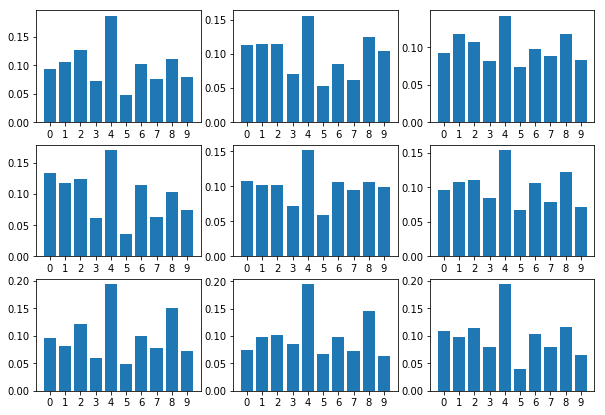

In [15]:
def plot_predictions():
    guess_pred = model.predict(x_test[:9])

    fig, axes = plt.subplots(3, 3, figsize=(10, 7))

    for pred, ax in zip(guess_pred, axes.flat):
        ax.bar(np.arange(10), pred)
        ax.set_xticks(np.arange(10))
        ax.set_xticklabels(np.arange(10))
        
plot_predictions()

`fit` beginnt den eigentlichen Trainingsprozess. Hier übergeben wir unsere Trainingsdaten und können die Länge des Trainings steuern.

In [16]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 52us/step - loss: 0.2513 - acc: 0.9238 - val_loss: 0.1057 - val_acc: 0.9672
Epoch 2/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.1016 - acc: 0.9684 - val_loss: 0.0811 - val_acc: 0.9741
Epoch 3/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0739 - acc: 0.9766 - val_loss: 0.0694 - val_acc: 0.9769
Epoch 4/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0575 - acc: 0.9815 - val_loss: 0.0646 - val_acc: 0.9802
Epoch 5/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0445 - acc: 0.9849 - val_loss: 0.0678 - val_acc: 0.9801
Epoch 6/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0403 - acc: 0.9866 - val_loss: 0.0688 - val_acc: 0.9807
Epoch 7/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0342 - acc: 0.9888 - val_loss: 0.0629 - val_acc

`fit` gibt ein `History`-Objekt zurück, welches den Trainingsverlauf aufzeichnet. Mit diesem kann man z.B. Trainingskurven erstellen und die Konvergenz des MLP beobachten.

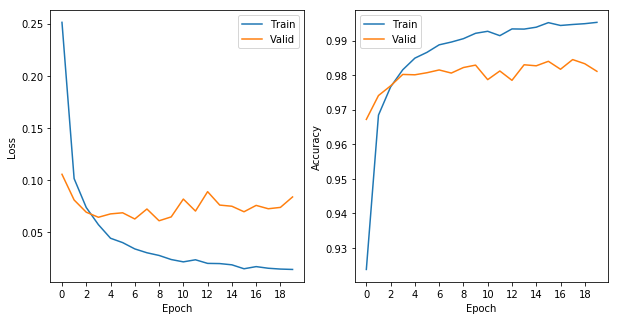

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history.epoch, history.history['loss'], label='Train')
ax1.plot(history.epoch, history.history['val_loss'], label='Valid')
ax1.set_ylabel('Loss')

ax2.plot(history.epoch, history.history['acc'], label='Train')
ax2.plot(history.epoch, history.history['val_acc'], label='Valid')
ax2.set_ylabel('Accuracy')

for ax in (ax1, ax2):
    ax.set_xticks(history.epoch[::2])
    ax.set_xlabel('Epoch')
    ax.legend()

None

Nach erfolgtem Training sind auch die Vorhersagen schärfer und die erreichte Genauigkeit liegt um die 98%

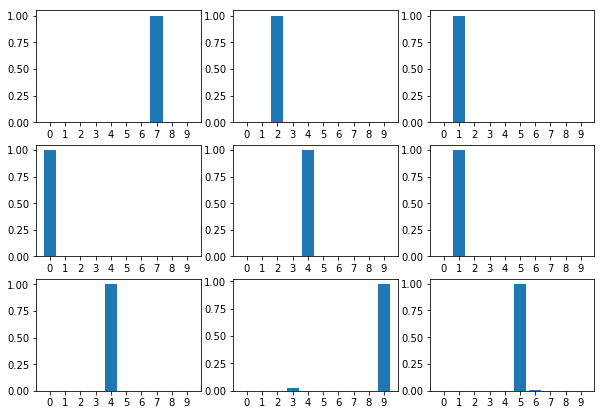

In [18]:
plot_predictions()

In [19]:
score = model.evaluate(x_test, y_test, verbose=0)

In [20]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0840292262601
Test accuracy: 0.9811
